<a href="https://colab.research.google.com/github/ATPONNUTTAYOTHIN781/Statistical-Learning-Labs/blob/main/Lab09_Neural_Networks_660510781.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##อรรถพล นุตตโยธิน 660510781

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

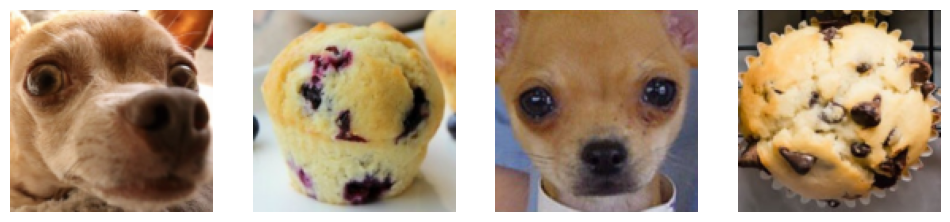

tensor([0, 1, 0, 1])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [13]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(128 * 128 * 3, 1) # Input: 128*128*3 (flattened image), Output: 1 (for binary classification)

    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten the image
        x = self.linear(x)
        x = torch.sigmoid(x) # Apply sigmoid for binary classification
        return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [14]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [15]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [16]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [17]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

#### Make a prediction on the minibatch (Forward pass)

In [41]:
for X, y in train_loader:
    # Forward pass
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [42]:
# Compute the loss

loss = criterion(y_hat, y)   # binary cross entropy loss



#### Calculate the gradient (Backward pass)

In [43]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()   # compute gradients w.r.t model parameters



In [44]:
model.parameters()

<generator object Module.parameters at 0x7cabcb8d73e0>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [45]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [46]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [47]:
print(train_losses)
print(val_losses)

[0.6931471824645996, 0.658240556716919, 0.7276516556739807, 0.7062033414840698, 0.6737984418869019, 0.7003011107444763, 0.708465576171875, 0.6888741850852966, 0.7377117276191711, 0.6795569062232971, 0.6838911175727844, 0.6437809467315674, 0.69688880443573, 0.6482601761817932, 0.678126335144043, 0.6624330282211304, 0.6437230706214905, 0.72125244140625, 0.6489136219024658, 0.6530779004096985, 0.6936240792274475, 0.6311705708503723, 0.6656377911567688, 0.6245575547218323, 0.623296856880188, 0.6841732263565063, 0.6372836828231812, 0.6484618782997131, 0.6251479387283325, 0.6686921715736389, 0.6287406086921692, 0.6307371854782104, 0.641870379447937, 0.6065836548805237, 0.6241374015808105, 0.6347035765647888, 0.6640921831130981, 0.6478520631790161, 0.6044327616691589, 0.6319161057472229, 0.6320945024490356, 0.5979218482971191, 0.6023138165473938, 0.626315712928772, 0.631819486618042, 0.6259751319885254, 0.5866678357124329, 0.6390687227249146, 0.6007154583930969, 0.5639657378196716, 0.57073807

#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

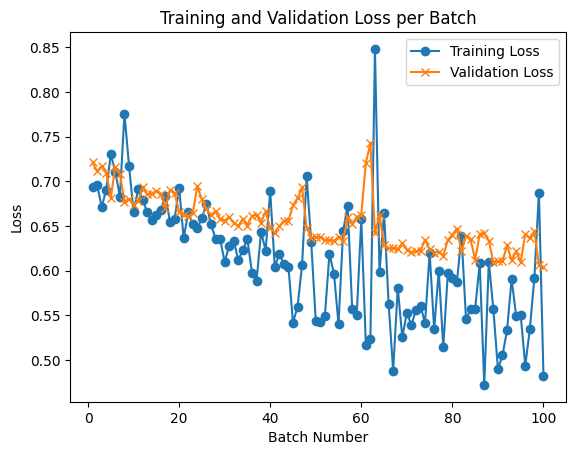

In [48]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [27]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


##ข้อ 1: สร้างโมเดล Neural Network (3 hidden layers)

In [28]:
# Define a neural network with 3 hidden layers
class ThreeHiddenNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

input_dim = 3 * 128 * 128  # matches image size from transform


##ข้อ 2: เทรนโมเดลด้วยหลายค่า Learning Rate

In [49]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    model = ThreeHiddenNet(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    epochs = 20
    for epoch in range(1, epochs+1):
        model.train()
        epoch_train_losses = []
        for X, y in train_loader:
            optimizer.zero_grad()
            y_true = y.to(torch.float32)
            y_hat = model(X).squeeze(1)
            loss = criterion(y_hat, y_true)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        # average training loss
        train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))

        # validation loss
        model.eval()
        with torch.no_grad():
            for Xv, yv in val_loader:
                yv = yv.to(torch.float32)
                yv_hat = model(Xv).squeeze(1)
                val_loss = criterion(yv_hat, yv)
                val_losses.append(val_loss.item())

        if epoch % 5 == 0 or epoch == 1:
            print(f" Epoch {epoch}/{epochs} - train loss: {train_losses[-1]:.4f} - val loss: {val_losses[-1]:.4f}")

    results[lr] = {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses
    }



Training with learning rate = 0.01
 Epoch 1/20 - train loss: 0.6926 - val loss: 0.6918
 Epoch 5/20 - train loss: 0.6204 - val loss: 0.6907
 Epoch 10/20 - train loss: 0.4725 - val loss: 0.5397
 Epoch 15/20 - train loss: 0.3011 - val loss: 0.4491
 Epoch 20/20 - train loss: 0.1899 - val loss: 0.4059

Training with learning rate = 0.001
 Epoch 1/20 - train loss: 0.6945 - val loss: 0.6866
 Epoch 5/20 - train loss: 0.6825 - val loss: 0.6844
 Epoch 10/20 - train loss: 0.6711 - val loss: 0.6779
 Epoch 15/20 - train loss: 0.6550 - val loss: 0.6700
 Epoch 20/20 - train loss: 0.6415 - val loss: 0.6641

Training with learning rate = 0.0001
 Epoch 1/20 - train loss: 0.6998 - val loss: 0.6892
 Epoch 5/20 - train loss: 0.6982 - val loss: 0.6890
 Epoch 10/20 - train loss: 0.6974 - val loss: 0.6889
 Epoch 15/20 - train loss: 0.6959 - val loss: 0.6888
 Epoch 20/20 - train loss: 0.6956 - val loss: 0.6886

Training with learning rate = 1e-05
 Epoch 1/20 - train loss: 0.6901 - val loss: 0.6951
 Epoch 5/20

2.1) จากผลการทดลองพบว่า learning rate = 1e-2 (0.01) ให้ผลดีที่สุด เนื่องจากค่า train loss และ validation loss ลดลงต่อเนื่องและได้ค่าที่ต่ำที่สุดเมื่อเทียบกับค่าอื่น ๆ แสดงว่ารุ่นสามารถเรียนรู้ได้เร็วและมีประสิทธิภาพ

2.2) ถ้า learning rate มีค่ามากเกินไป ค่า train loss จะไม่สามารถลดลงได้อย่างสม่ำเสมอ อาจเกิดอาการแกว่งขึ้นลงหรือไม่ลดเลย เพราะการอัปเดตน้ำหนักแต่ละครั้งกระโดดไกลเกินไป ทำให้ไม่สามารถเข้าใกล้จุดต่ำสุดของ loss function ได้

2.3) ถ้า learning rate มีค่าต่ำเกินไป การเรียนรู้จะช้ามาก ทำให้ train loss ลดลงช้า หรือแทบไม่ลดลงเลยเหมือนในกรณี 1e-4 และ 1e-5 เนื่องจากการอัปเดตน้ำหนักในแต่ละรอบมีขนาดเล็กเกินไป

##ข้อ 3: คำนวณ Accuracy บน Test Set

In [50]:
# Helper to evaluate accuracy and collect misclassified images
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    misclassified = []
    with torch.no_grad():
        for X, y in loader:
            y = y.to(torch.float32)
            y_hat = model(X).squeeze(1)
            preds = (y_hat > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.shape[0]
            for i in range(len(y)):
                if preds[i].item() != y[i].item() and len(misclassified) < 8:
                    misclassified.append((X[i].cpu(), int(y[i].item()), int(preds[i].item())))
    accuracy = correct / total if total > 0 else 0.0
    return accuracy, misclassified

# คำนวณ accuracy ของแต่ละ learning rate
for lr in learning_rates:
    acc, mis = evaluate_model(results[lr]["model"], test_loader)
    results[lr]["test_accuracy"] = acc
    results[lr]["misclassified"] = mis
    print(f"Test accuracy for lr={lr}: {acc*100:.2f}%")


Test accuracy for lr=0.01: 80.00%
Test accuracy for lr=0.001: 66.67%
Test accuracy for lr=0.0001: 43.33%
Test accuracy for lr=1e-05: 56.67%


##ข้อ 4: แสดงภาพที่ทำนายผิด


Best learning rate by test accuracy: 0.01 (accuracy=80.00%)


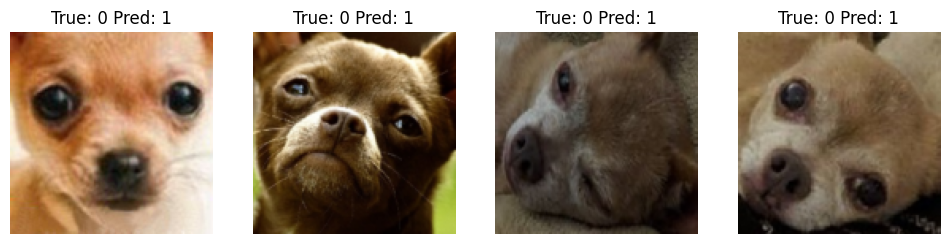

In [51]:
# เลือกโมเดลที่ดีที่สุด (accuracy สูงสุด)
best_lr = max(results.keys(), key=lambda k: results[k]["test_accuracy"])
print(f"\nBest learning rate by test accuracy: {best_lr} "
      f"(accuracy={results[best_lr]['test_accuracy']*100:.2f}%)")

mis = results[best_lr]["misclassified"]

# ถ้ามีภาพผิดน้อยกว่า 4 เติมจาก lr อื่น
if len(mis) < 4:
    for lr in learning_rates:
        for item in results[lr]["misclassified"]:
            if item not in mis:
                mis.append(item)
            if len(mis) >= 4:
                break
        if len(mis) >= 4:
            break

# แสดง 4 ภาพแรกที่ผิด
n_show = min(4, len(mis))
plt.figure(figsize=(12,3))
for i in range(n_show):
    img_tensor, true_label, pred_label = mis[i]
    img = img_tensor.permute(1,2,0).numpy()
    plt.subplot(1, n_show, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label} Pred: {pred_label}")
    plt.axis('off')
plt.show()
